In [2]:
import os
def list_all_files(dir:str)->list[str]:
  files = os.listdir(dir)
  return files

In [3]:
TRAIN_IMG_BASE = "wb_localization_dataset/images/train"
VAL_IMG_BASE = "wb_localization_dataset/images/val"
train_img_paths = list_all_files(TRAIN_IMG_BASE)
val_img_paths = list_all_files(VAL_IMG_BASE)

TRAIN_LABEL_BASE = "wb_localization_dataset/labels/train"
VAL_LABEL_BASE = "wb_localization_dataset/labels/val"
train_label_paths = list_all_files(TRAIN_LABEL_BASE)
val_label_paths = list_all_files(VAL_LABEL_BASE)
def remove_extension(path: str) -> str:
    return path[:path.index(".")]
def get_full_path(name: str, base: str) -> str:
    return os.path.join(base,name)
from keras.preprocessing.image import load_img
load_img(get_full_path(train_img_paths[0], TRAIN_IMG_BASE))
train_img_paths = sorted([get_full_path(train_img_path, TRAIN_IMG_BASE) for train_img_path in train_img_paths])
val_img_paths = sorted([get_full_path(val_img_path, VAL_IMG_BASE) for val_img_path in val_img_paths])
train_label_paths = sorted([get_full_path(train_label_path, TRAIN_LABEL_BASE) for train_label_path in train_label_paths])
val_label_paths = sorted([get_full_path(val_label_path, VAL_LABEL_BASE) for val_label_path in val_label_paths])


2024-05-22 23:43:57.320249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 23:43:58.429969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from typing import List, NamedTuple, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch


class Location(NamedTuple):
    center_x: float  # center_x/image_width
    center_y: float  # center_y/image_height
    width: float  # width/image_width
    height: float  # height/image_height


class Point(NamedTuple):
    x: int
    y: int

def draw_bounding_box(img, bboxes):
        img = np.ascontiguousarray(img)
        H, W, C = img.shape
        for box in bboxes:
            center_x = box[0] * W
            center_y = box[1] * H
            height = box[3] * H
            width = box[2] * W
            top_left = Point(int(center_x - width / 2), int(center_y - height / 2))
            bottom_right = Point(int(center_x + width / 2), int(center_y + height / 2))
            cv2.rectangle(img, top_left, bottom_right, (255, 0, 0), 2)
        plt.imshow(img)
        plt.show()

In [7]:
import uuid

def load_bboxes(path:str):
  with open(path) as f:
    bboxes = []
    for line in f:
      params = list(map(float, line.split()[1:]))
      bboxes.append(params)
    return bboxes

def convert_bboxes_to_full_labels(bboxes_list):
  labels_list = []
  for bboxes in bboxes_list:
    labels = []
    for bbox in bboxes:
      label = bbox + [0]
      labels.append(label)
    labels_list.append(labels)
  return labels_list

def save(images, bboxes_list, method):
  i = 0
  for image, bboxes in zip(images,bboxes_list):
    # id = uuid.uuid4()
    cv2.imwrite(filename=f"images/{method}_{i}.jpg", img=image)
    with open(f"labels/{method}_{i}.txt", "w") as f:
      for box in bboxes:
        if len(box) == 4:
          params = " ".join(list(map(str,box)))
          f.write(f"0 {params}\n")
        elif len(box) == 5:
          params = " ".join(list(map(str,box[:4])))
          f.write(f"0 {params}\n")
    i += 1 


In [8]:
import albumentations as A
from enum import Enum
import numpy as np


class FlipMode(Enum):
    horizontal = "horizontal"
    vertical = "vertical"


class FlipAugmentation:
    """
    Flipping image for data augmentation
    Two mode: horizontal flip and vertical flip
    """

    def __init__(self, images, bboxes_list, mode: str = "horizontal"):
        self.mode = mode

        transformed_list = (
            [
                self._flip_horizontal(image, bboxes)
                for image, bboxes in zip(images, bboxes_list)
            ]
            if mode == "horizontal"
            else [
                self._flip_vertical(image, bboxes)
                for image, bboxes in zip(images, bboxes_list)
            ]
        )
        self.images = [transformed[0] for transformed in transformed_list]
        self.bboxes_list = [transformed[1] for transformed in transformed_list]

    def __getitem__(self, idx: int):
        return self.images[idx], self.bboxes_list[idx]

    def _flip_horizontal(self, image, boxes):
        """
        box: x_center, y_center, width, height\n
        x_center = x_center_pixel / image_width\n
        y_center = y_center_pixel / image_height\n
        width = box_width / image_width\n
        height = box_height / image_height
        """

        # transform = A.Compose(
        #     [A.HorizontalFlip(p=1)],
        #     bbox_params=A.BboxParams(format="yolo", min_visibility=0.5),
        # )

        # transformed = transform(image=image, bboxes=boxes)
        # transformed_image = transformed["image"]
        # transformed_bboxes = transformed["bboxes"]
        # return transformed_image, transformed_bboxes

        def get_flip(num):
            return 1 - num

        new_boxes = []
        for box in boxes:
            new_box = [
                get_flip(box[0]),
                box[1],
                box[2],
                box[3],
            ]
            new_boxes.append(new_box)

        return np.fliplr(image), new_boxes

    def _flip_vertical(self, image, boxes):
        """
        box: x_center, y_center, width, height\n
        x_center = x_center_pixel / image_width\n
        y_center = y_center_pixel / image_height\n
        width = box_width / image_width\n
        height = box_height / image_height
        """

        # transform = A.Compose(
        #     [A.VerticalFlip(p=1)],
        #     bbox_params=A.BboxParams(format="yolo", min_visibility=0.5),
        # )

        # transformed = transform(image=image, bboxes=boxes)
        # transformed_image = transformed["image"]
        # transformed_bboxes = transformed["bboxes"]
        # return transformed_image, transformed_bboxes

        def get_flip(num):
            return 1 - num

        new_boxes = []
        for box in boxes:
            new_box = [
                box[0],
                get_flip(box[1]),
                box[2],
                box[3],
            ]
            new_boxes.append(new_box)
        return np.flipud(image), new_boxes

    def __call__(self, input, boxes):
        if self.mode == FlipMode.horizontal:
            return self._flip_horizontal(input, boxes)
        elif self.mode == FlipMode.vertical:
            return self._flip_vertical(input, boxes)
        else:
            raise Exception(
                "There are only 'horizontal' and 'vertical' mode in FlipAugmentation"
            )


In [9]:
bboxes_list = [load_bboxes(path=train_label_path) for train_label_path in train_label_paths]
images = [cv2.cvtColor(cv2.imread(train_image_path), cv2.COLOR_BGR2RGB) for train_image_path in train_img_paths]

In [10]:
horizontal_augmentation = FlipAugmentation(images, bboxes_list)
save(horizontal_augmentation.images, horizontal_augmentation.bboxes_list, method="horizontal")

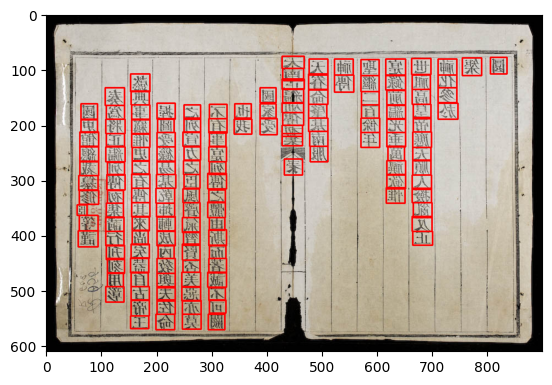

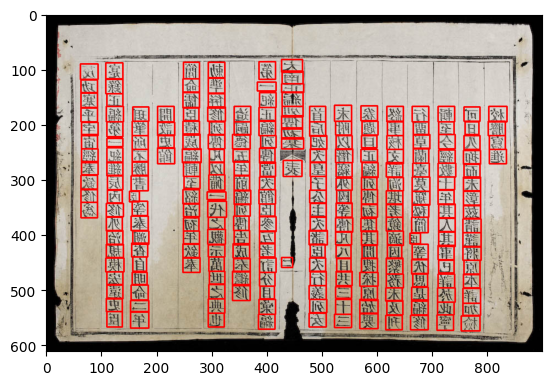

In [11]:
draw_bounding_box(horizontal_augmentation.images[0], horizontal_augmentation.bboxes_list[0])
draw_bounding_box(horizontal_augmentation.images[1], horizontal_augmentation.bboxes_list[1])

In [13]:
vertical_augmentation = FlipAugmentation(images, bboxes_list, mode="vertical")
save(vertical_augmentation.images,vertical_augmentation.bboxes_list,method="vertical")

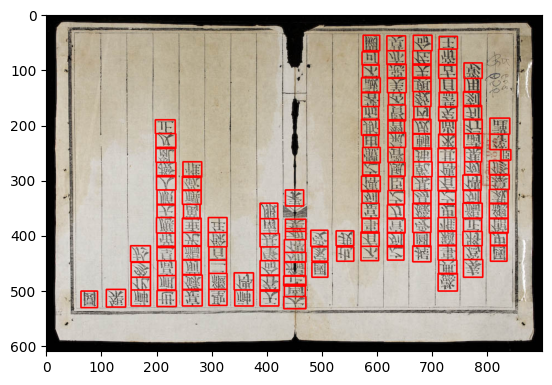

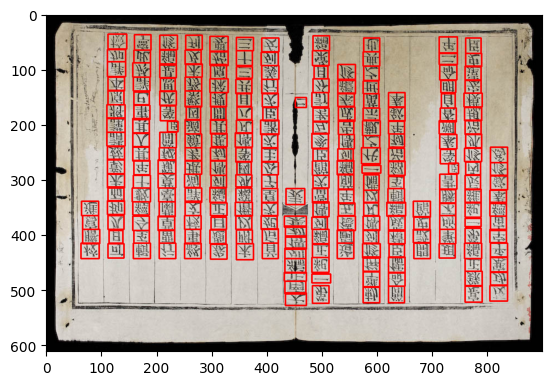

In [14]:
draw_bounding_box(vertical_augmentation.images[0], vertical_augmentation.bboxes_list[0])
draw_bounding_box(vertical_augmentation.images[1], vertical_augmentation.bboxes_list[1])

In [15]:
import albumentations as A


class CropAugmentation:
    """
    Cropping image for data augmentation
    """

    def __init__(self, images, bboxes_list):

        transformed_list = [
            self._crop(image, bboxes) for image, bboxes in zip(images, bboxes_list)
        ]
        self.images = [transformed[0] for transformed in transformed_list]
        self.bboxes_list = [transformed[1] for transformed in transformed_list]

    def __getitem__(self, idx: int):
        return self.images[idx], self.bboxes_list[idx]

    def _crop(self, image, bboxes):
        """
        box: x_center, y_center, width, height\n
        x_center = x_center_pixel / image_width\n
        y_center = y_center_pixel / image_height\n
        width = box_width / image_width\n
        height = box_height / image_height
        """

        transform = A.Compose(
            [A.RandomCrop(width=500, height=500), A.RandomBrightnessContrast(p=0.1)],
            bbox_params=A.BboxParams(format="yolo", min_visibility=0.5),
        )

        transformed = transform(image=image, bboxes=bboxes)
        transformed_image = transformed["image"]
        transformed_bboxes = transformed["bboxes"]
        return transformed_image, transformed_bboxes


In [19]:
crop_augmentation = CropAugmentation(images, convert_bboxes_to_full_labels(bboxes_list))
save(crop_augmentation.images,crop_augmentation.bboxes_list,method="crop")

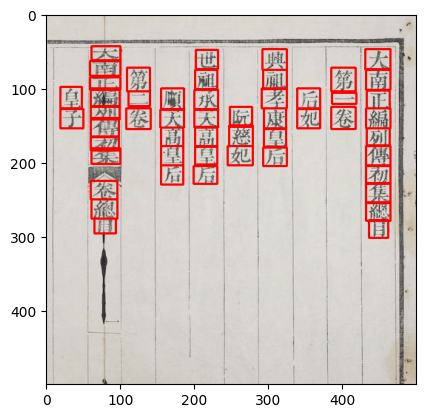

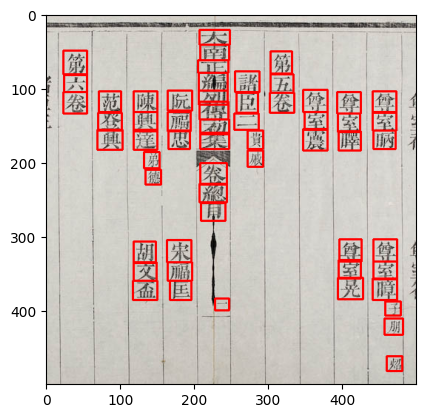

In [20]:
draw_bounding_box(crop_augmentation.images[5], crop_augmentation.bboxes_list[5])
draw_bounding_box(crop_augmentation.images[6], crop_augmentation.bboxes_list[6])

In [21]:
import cv2 as cv
import numpy as np
import albumentations as A


class KernelFilterAugmentation:
    def __init__(self, images, bboxes_list, kernel_size=5):
        self.kernel_size = kernel_size
        transformed_list = [
            self._blur(image, bboxes) for image, bboxes in zip(images, bboxes_list)
        ]
        self.images = [transformed[0] for transformed in transformed_list]
        self.bboxes_list = [transformed[1] for transformed in transformed_list]

    def __getitem__(self, idx: int):
        return self.images[idx], self.bboxes_list[idx]

    def _blur(self, image, bboxes):

        # transform = A.Compose(
        #     [A.GaussianBlur(blur_limit=(self.kernel_size, self.kernel_size), always_apply=True)],
        #     bbox_params=A.BboxParams(format="yolo", min_visibility=0.5),
        # )
        # transformed = transform(image=image, bboxes=bboxes)
        # transformed_image = transformed["image"]
        # transformed_bboxes = transformed["bboxes"]
        # return transformed_image, transformed_bboxes

        kernel = cv.getGaussianKernel(self.kernel_size, 0)
        gaussian_kernel = np.matmul(kernel, kernel.transpose())

        blur_image = cv.filter2D(image, -1, gaussian_kernel)
        return blur_image, bboxes


In [22]:
kernel_augmentation = KernelFilterAugmentation(images, bboxes_list)
save(kernel_augmentation.images,kernel_augmentation.bboxes_list,method="kernel")

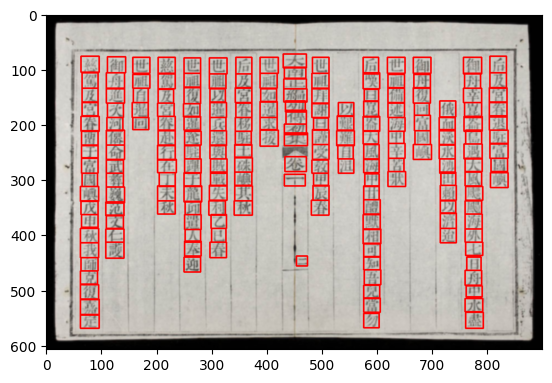

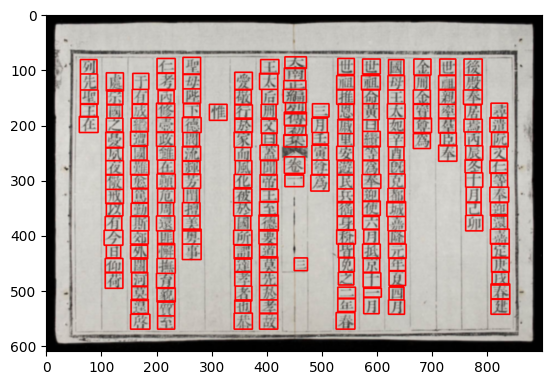

In [24]:
draw_bounding_box(kernel_augmentation.images[20], kernel_augmentation.bboxes_list[20])
draw_bounding_box(kernel_augmentation.images[21], kernel_augmentation.bboxes_list[21])

In [25]:
import numpy as np
import cv2
import albumentations as A
from enum import Enum


class NoiseInjectAugmentation:
    """
    Randomly injecting noise into image
    """

    def __init__(self, images, bboxes_list, mean=0, std=25):
        self.mean = mean
        self.std = std
        transformed_list = [
            self._add_gaussian_noise(image, bboxes)
            for image, bboxes in zip(images, bboxes_list)
        ]
        self.images = [transformed[0] for transformed in transformed_list]
        self.bboxes_list = [transformed[1] for transformed in transformed_list]

    def __getitem__(self, idx: int):
        return self.images[idx], self.bboxes_list[idx]

    def _add_gaussian_noise(self, image, bboxes):
        """
        Adding gauss distribution noise into image

        Params:
            image: original image
            mean: mean value of gauss distribution (=0 by default)
            std: standard deviation of gauss distribution (=25 by default)

        Returns:
            numpy.ndarray: image after adding gauss distribution noise
            bboxes: all bounding boxes in converted image
        """

        # transform = A.Compose(
        #     [A.GaussNoise(var_limit=(0, self.std), mean=self.mean, always_apply=True)],
        #     bbox_params=A.BboxParams(format="yolo", min_visibility=0.5),
        # )
        # transformed = transform(image=image, bboxes=bboxes)
        # transformed_image = transformed["image"]
        # transformed_bboxes = transformed["bboxes"]
        # return transformed_image, transformed_bboxes

        noise = np.random.normal(self.mean, self.std, image.shape)
        # avoid out-of-range value and capture value from float to int
        added_noise_image = np.clip(image + noise, 0, 255).astype(np.uint8)
        return added_noise_image, bboxes


In [26]:
noise_inject_augmentation = NoiseInjectAugmentation(images, bboxes_list)
save(noise_inject_augmentation.images, noise_inject_augmentation.bboxes_list, method="noise_inject")

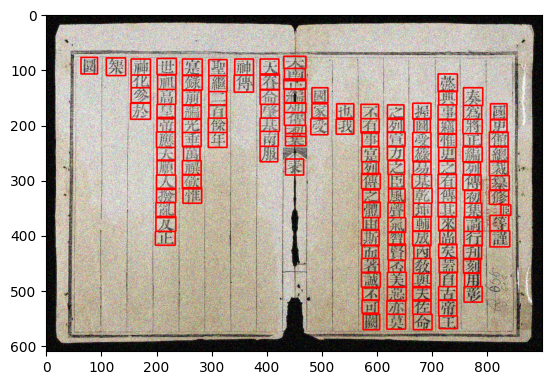

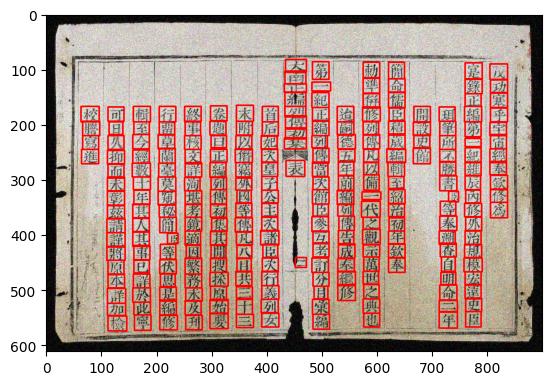

In [27]:
draw_bounding_box(noise_inject_augmentation.images[0], noise_inject_augmentation.bboxes_list[0])
draw_bounding_box(noise_inject_augmentation.images[1], noise_inject_augmentation.bboxes_list[1])

In [28]:
import cv2 as cv
import numpy as np
import albumentations as A
import torchvision.transforms as torch_transforms


class RandomErasingAugmentation:
    def __init__(self, images, bboxes_list):
        transformed_list = [
            self._random_erase(image, bboxes)
            for image, bboxes in zip(images, bboxes_list)
        ]
        self.images = [transformed[0] for transformed in transformed_list]
        self.bboxes_list = [transformed[1] for transformed in transformed_list]

    def __getitem__(self, idx: int):
        return self.images[idx], self.bboxes_list[idx]

    def _random_erase(self, image, bboxes):

        # transform = torch_transforms.Compose(
        #     [
        #         torch_transforms.ToTensor(),
        #         torch_transforms.RandomErasing(
        #             p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value="random"
        #         ),
        #     ]
        # )
        transform = A.Compose(
            [
                A.CoarseDropout(
                    always_apply=True,
                    min_holes=25,
                    max_holes=100,
                    num_holes_range=[25, 100],
                    fill_value=255,
                )
            ],
            # bbox_params=A.BboxParams(format="yolo", min_visibility=0.5),
        )
        transformed = transform(image=image)
        transformed_image = transformed["image"]
        # transformed_bboxes = transformed["bboxes"]
        return transformed_image, bboxes


In [29]:
random_erase_augmentation = RandomErasingAugmentation(images, bboxes_list)
save(random_erase_augmentation.images, random_erase_augmentation.bboxes_list, method="random_erase")

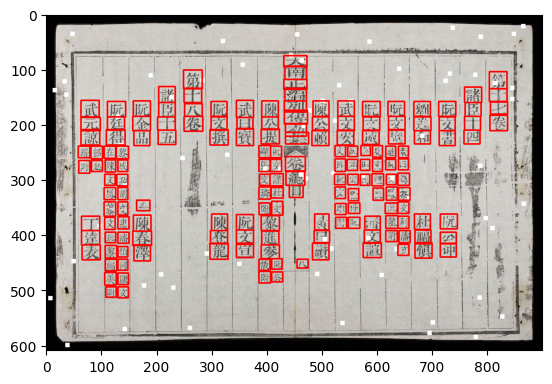

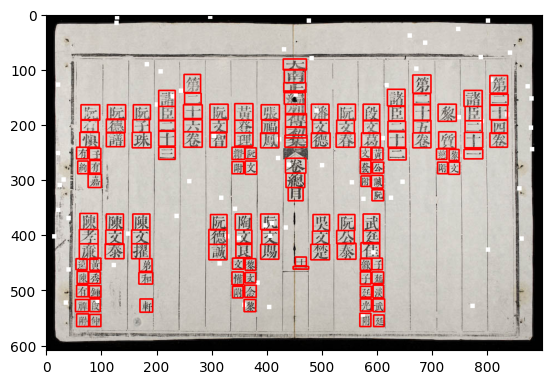

In [30]:
draw_bounding_box(random_erase_augmentation.images[12], random_erase_augmentation.bboxes_list[12])
draw_bounding_box(random_erase_augmentation.images[15], random_erase_augmentation.bboxes_list[15])

In [32]:
class MorphologicalAugmentation:
    def __init__(self, images, bboxes_list, mode: str="erosion"):
        self.mode = mode 

        self.images = [self._erosion(image) if self.mode == "erosion" else self._dilation(image) for image in images]
        self.bboxes_list = bboxes_list
    def __getitem__(self, idx: int): 
        return self.images[idx], self.bboxes_list[idx]

    def _erosion(self, image):
        transform = A.Compose(
            [A.Morphological(operation="erosion", always_apply=True)],
        )
        transformed = transform(image=image)
        transformed_image = transformed["image"]
        return transformed_image
    
    def _dilation(self, image):
        transform = A.Compose(
            [A.Morphological(operation="dilation", always_apply=True)],
        )
        transformed = transform(image=image)
        transformed_image = transformed["image"]
        return transformed_image

In [33]:
erosion_augmentation = MorphologicalAugmentation(images=images, bboxes_list=convert_bboxes_to_full_labels(bboxes_list))
dilation_augmentation = MorphologicalAugmentation(images=images, bboxes_list=convert_bboxes_to_full_labels(bboxes_list), mode="dilation")

In [34]:
save(erosion_augmentation.images, erosion_augmentation.bboxes_list, method='erosion')
save(dilation_augmentation.images, dilation_augmentation.bboxes_list, method="dilation")

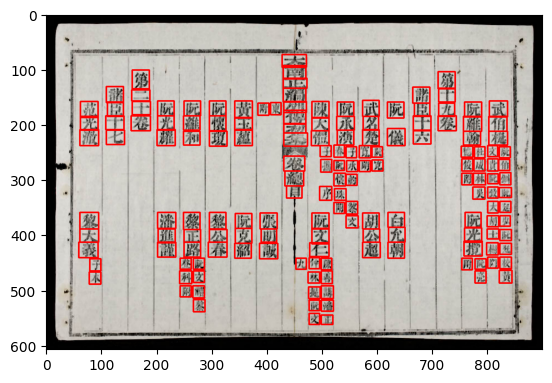

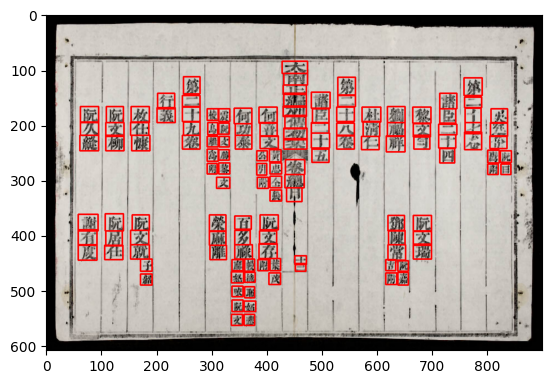

In [36]:
draw_bounding_box(erosion_augmentation.images[13], erosion_augmentation.bboxes_list[13])
draw_bounding_box(erosion_augmentation.images[16], erosion_augmentation.bboxes_list[16])

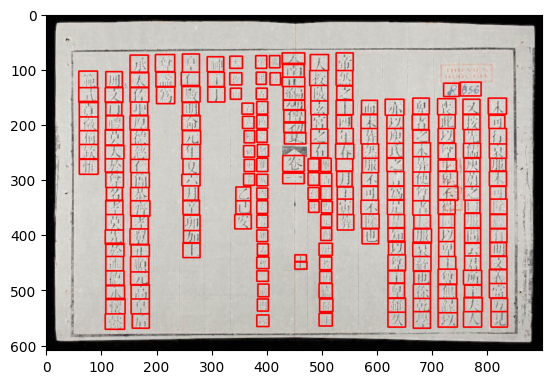

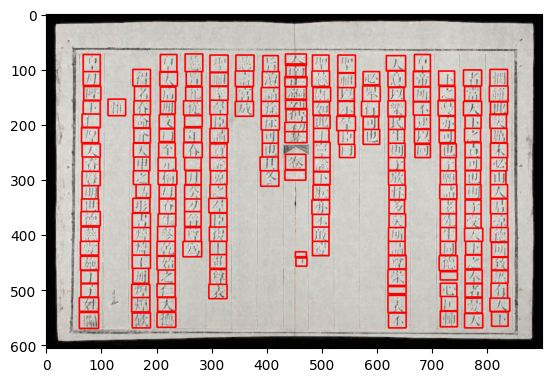

In [37]:
draw_bounding_box(dilation_augmentation.images[35], dilation_augmentation.bboxes_list[35])
draw_bounding_box(dilation_augmentation.images[40], dilation_augmentation.bboxes_list[40])